# Esse Tutorial mostra como criar um classificador de imagens usando redes neurais convolucionais capaz de diferenciar classes de imagens utilizando tf.keras no Google Colab.

# Aqui, vamos cobrir:
- importação de dados
- pré-processamento
- criação do modelo
- treinamento
- avaliação
- predições

# Antes de começar, alterar o ambiente de execução para GPU

## 1. Importação das bibliotecas necessárias

In [ ]:
import os
from zipfile import ZipFile
import shutil
import gdown
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 2. Download e descompactação da base de dados

In [ ]:
!gdown 1jLm7U5Nin_7LQVW1F-sGvHdcJ52t5_6V


Downloading...
From: https://drive.google.com/uc?id=1jLm7U5Nin_7LQVW1F-sGvHdcJ52t5_6V
To: /content/imagens-tratadas-data.zip
100% 6.73M/6.73M [00:00<00:00, 8.19MB/s]


In [ ]:
file_name = "imagens-tratadas-data.zip"

with ZipFile(file_name, 'r') as zip:
    dataset_home = './'
    os.makedirs(dataset_home, exist_ok=True)

    zip.printdir()

    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
imagens-tratadas-data/train_set/               2024-02-28 10:11:30            0
imagens-tratadas-data/train_set/anormais-segmentadas/ 2024-02-28 10:12:56            0
imagens-tratadas-data/train_set/anormais-segmentadas/mdb001_mod.png 2024-02-28 00:08:00        27046
imagens-tratadas-data/train_set/anormais-segmentadas/mdb002_mod.png 2024-02-28 00:08:00        18312
imagens-tratadas-data/train_set/anormais-segmentadas/mdb005_mod.png 2024-02-28 00:08:00        23447
imagens-tratadas-data/train_set/anormais-segmentadas/mdb005'_mod.png 2024-02-28 00:08:00        24041
imagens-tratadas-data/train_set/anormais-segmentadas/mdb010_mod.png 2024-02-28 00:08:00        24806
imagens-tratadas-data/train_set/anormais-segmentadas/mdb012_mod.png 2024-02-28 00:08:00        29314
imagens-tratadas-data/train_set/anormais-segmentadas/mdb013_mod.png 2024-02-28 00:08:00        22169
imagens-tratadas-data/train_set/anormais-segm

## 3. Carregamento e pré-processamento das imagens (Aplicando Data augmentation e balanceamento de classes)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    'imagens-tratadas-data/train_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'imagens-tratadas-data/val_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

from collections import Counter

print("\nVerificando balanceamento do dataset:")
train_normal_count = len(os.listdir('imagens-tratadas-data/train_set/normais-redimensionadas'))
train_anormal_count = len(os.listdir('imagens-tratadas-data/train_set/anormais-segmentadas'))

val_normal_count = len(os.listdir('imagens-tratadas-data/val_set/normais-redimensionadas'))
val_anormal_count = len(os.listdir('imagens-tratadas-data/val_set/anormais-segmentadas'))

print(f"Treino -> Normais: {train_normal_count}, Anormais: {train_anormal_count}")
print(f"Validação -> Normais: {val_normal_count}, Anormais: {val_anormal_count}")

counter = Counter(train_generator.classes)
max_samples = float(max(counter.values()))

class_weights = {class_id: max_samples/num_images for class_id, num_images in counter.items()}
print(f"\nPesos de classe aplicados: {class_weights}")

Found 286 images belonging to 2 classes.
Found 44 images belonging to 2 classes.

Verificando balanceamento do dataset:
Treino -> Normais: 187, Anormais: 99
Validação -> Normais: 22, Anormais: 22

Pesos de classe aplicados: {np.int32(0): 1.8888888888888888, np.int32(1): 1.0}


## 4. Definição dos modelos

### 4.1 Definição CNN do zero:

In [ ]:
print("\n--- Definição da CNN Implementada do Zero (model_cnn_zero) ---")
model_cnn_zero = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


--- Definição da CNN Implementada do Zero (model_cnn_zero) ---


In [ ]:
model_cnn_zero.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_cnn_zero.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Definição da VGG16 e ResNet152V2 para Transfer Learning

In [ ]:
import keras

model_vgg = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3)
)

model_vgg.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
import keras

model_rsn = keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
)

model_rsn.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [ ]:
model = Sequential([
    model_rsn,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 5. Extração de características

In [ ]:
feature_extractor = Sequential([
    model_rsn,
    Flatten()
])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def extract_features(generator, extractor):
    features = []
    labels = []

    for batch_imgs, batch_labels in generator:
        batch_features = extractor.predict(batch_imgs)
        features.append(batch_features)
        labels.append(batch_labels)

        if len(features) * generator.batch_size >= generator.samples:
            break

    return np.vstack(features), np.hstack(labels)


In [ ]:
X_train, y_train = extract_features(train_generator, feature_extractor)
X_val, y_val = extract_features(validation_generator, feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


## 5. Treinamento dos modelos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(
    n_neighbors=7,
    metric='euclidean',
    weights='uniform'
)
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

In [ ]:
from sklearn.svm import SVC

svc = SVC(
    kernel='linear',
    probability=True,
    C=0.1,
    gamma='scale'
)
svc.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8026 - loss: 0.7550 - val_accuracy: 0.9773 - val_loss: 0.2648
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.9287 - loss: 0.3174 - val_accuracy: 0.9773 - val_loss: 0.3482
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.9830 - loss: 0.1570 - val_accuracy: 0.9318 - val_loss: 0.4249
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.9665 - loss: 0.1297 - val_accuracy: 0.9318 - val_loss: 0.4637
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.9805 - loss: 0.1430 - val_accuracy: 0.9545 - val_loss: 0.3890


In [ ]:
print("\n--- Treinamento da CNN Implementada do Zero (model_cnn_zero) ---")
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_cnn_zero = model_cnn_zero.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    class_weight=class_weights
)


--- Treinamento da CNN Implementada do Zero (model_cnn_zero) ---
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5190 - loss: 1.9649 - val_accuracy: 0.5000 - val_loss: 0.6855
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.6765 - loss: 0.8400 - val_accuracy: 0.5682 - val_loss: 0.6719
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6508 - loss: 0.8365 - val_accuracy: 0.8409 - val_loss: 0.6555
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.7227 - loss: 0.7386 - val_accuracy: 0.9318 - val_loss: 0.6513
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.8444 - loss: 0.6897 - val_accuracy: 0.9318 - val_loss: 0.5815
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.8262 - loss: 0.6902 - val_accuracy: 0.9318 - val_loss: 0.5465
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8646 - loss: 0.5498 - val_accuracy: 0.8409 - val_loss: 0.3898
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - ac

## 6. Verificando a acurácia dos modelos


In [ ]:
from scipy.stats import norm

def calculate_confidence_interval(accuracy, n_samples, confidence_level=0.95):
    if n_samples == 0:
        return (0.0, 0.0)

    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    standard_error = np.sqrt((accuracy * (1 - accuracy)) / n_samples)

    margin_of_error = z_score * standard_error

    lower_bound = accuracy - margin_of_error
    upper_bound = accuracy + margin_of_error

    lower_bound = max(0.0, lower_bound)
    upper_bound = min(1.0, upper_bound)

    return (lower_bound, upper_bound)

N_val = len(y_val)

print("\n--- Intervalos de Confiança (IC) de 95% para Modelos Clássicos ---")

knn_accuracy = accuracy_score(y_val, knn.predict(X_val))
knn_ci_lower, knn_ci_upper = calculate_confidence_interval(knn_accuracy, N_val)
print(f"KNN Accuracy: {knn_accuracy:.4f} (IC 95%: [{knn_ci_lower:.4f}, {knn_ci_upper:.4f}])")

svc_accuracy = accuracy_score(y_val, svc.predict(X_val))
svc_ci_lower, svc_ci_upper = calculate_confidence_interval(svc_accuracy, N_val)
print(f"SVC Accuracy: {svc_accuracy:.4f} (IC 95%: [{svc_ci_lower:.4f}, {svc_ci_upper:.4f}])")

rf_accuracy = accuracy_score(y_val, rf.predict(X_val))
rf_ci_lower, rf_ci_upper = calculate_confidence_interval(rf_accuracy, N_val)
print(f"Random Forest Accuracy: {rf_accuracy:.4f} (IC 95%: [{rf_ci_lower:.4f}, {rf_ci_upper:.4f}])")

_, nn_accuracy = model.evaluate(validation_generator, verbose=0)
nn_ci_lower, nn_ci_upper = calculate_confidence_interval(nn_accuracy, validation_generator.samples)
print(f"ResNet (TL) Accuracy: {nn_accuracy:.4f} (IC 95%: [{nn_ci_lower:.4f}, {nn_ci_upper:.4f}])")

_, cnn_zero_accuracy = model_cnn_zero.evaluate(validation_generator, verbose=0)
cnn_zero_ci_lower, cnn_zero_ci_upper = calculate_confidence_interval(cnn_zero_accuracy, validation_generator.samples)
print(f"CNN do Zero Accuracy: {cnn_zero_accuracy:.4f} (IC 95%: [{cnn_zero_ci_lower:.4f}, {cnn_zero_ci_upper:.4f}])")


--- Intervalos de Confiança (IC) de 95% para Modelos Clássicos ---
KNN Accuracy: 0.8409 (IC 95%: [0.7328, 0.9490])
SVC Accuracy: 0.9773 (IC 95%: [0.9332, 1.0000])
Random Forest Accuracy: 0.9091 (IC 95%: [0.8241, 0.9940])
ResNet (TL) Accuracy: 0.9545 (IC 95%: [0.8930, 1.0000])
CNN do Zero Accuracy: 0.9773 (IC 95%: [0.9332, 1.0000])


In [ ]:

y_pred = knn.predict(X_val)

print("KNN Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


KNN Accuracy: 0.8409090909090909
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86        22
         1.0       0.94      0.73      0.82        22

    accuracy                           0.84        44
   macro avg       0.86      0.84      0.84        44
weighted avg       0.86      0.84      0.84        44



In [ ]:

y_pred = svc.predict(X_val)

print("SVC Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


SVC Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        22
         1.0       0.96      1.00      0.98        22

    accuracy                           0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



In [ ]:

y_pred = rf.predict(X_val)

# Resultados
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Random Forest Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90        22
         1.0       0.85      1.00      0.92        22

    accuracy                           0.91        44
   macro avg       0.92      0.91      0.91        44
weighted avg       0.92      0.91      0.91        44



In [ ]:

loss, accuracy = model.evaluate(validation_generator)
print("Accuracy: ", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9593 - loss: 0.2720
Accuracy:  0.9545454382896423


In [ ]:
print("\n--- Avaliação da CNN Implementada do Zero (model_cnn_zero) ---")
loss_cnn_zero, accuracy_cnn_zero = model_cnn_zero.evaluate(validation_generator)
print("CNN do Zero Accuracy: ", accuracy_cnn_zero)


--- Avaliação da CNN Implementada do Zero (model_cnn_zero) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9744 - loss: 0.3433
CNN do Zero Accuracy:  0.9772727489471436


## 7. Realizar predições e visualizar-las


Acurácia dos modelos:
---------------------
ResNet:                    0.9545454383
CNN do Zero:               0.9772727489
Random Forest:             0.9090909091
SVC:                       0.9772727273
KNN:                       0.8409090909



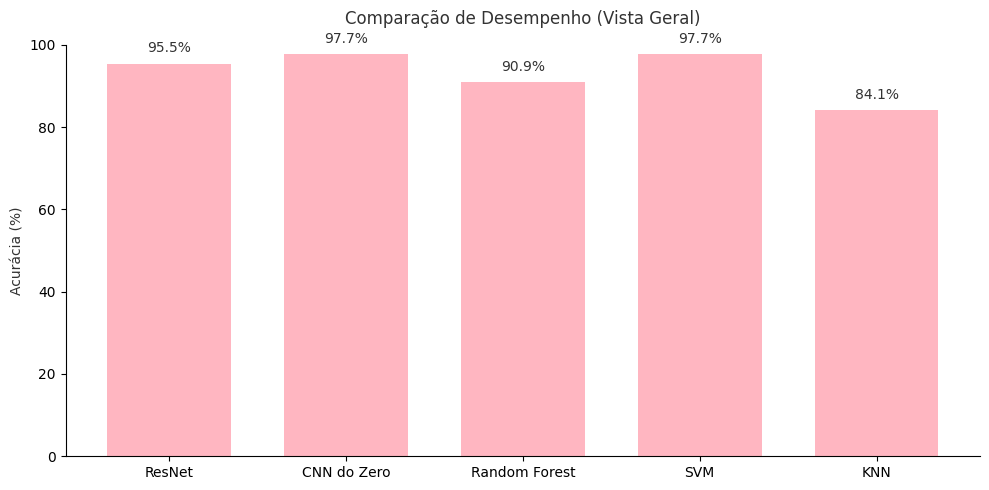

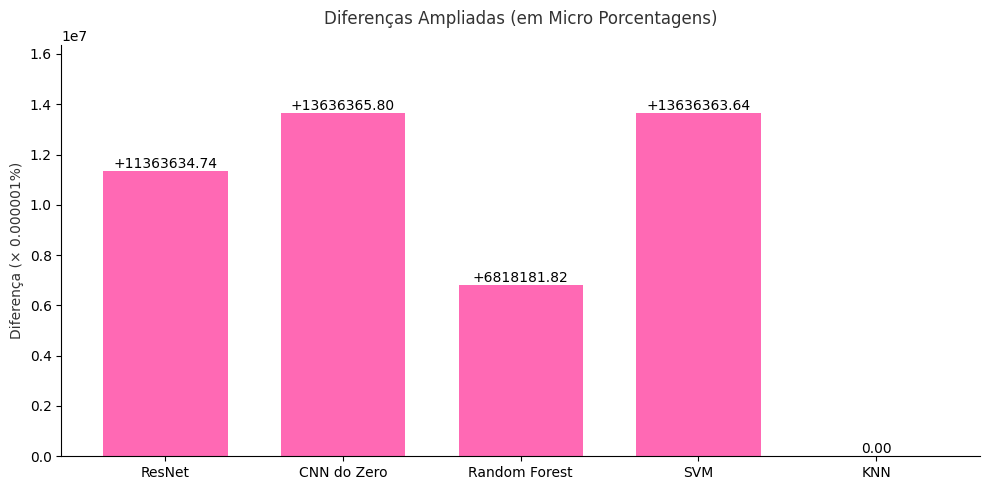

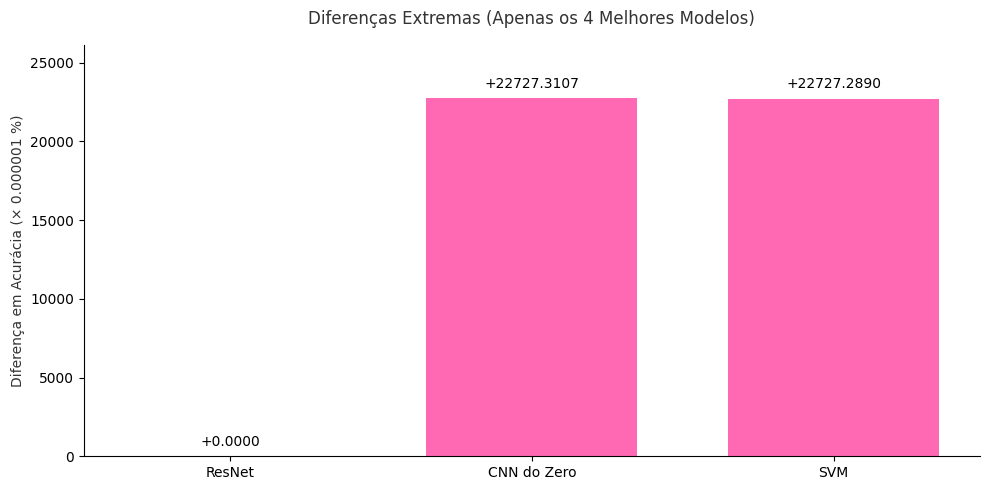

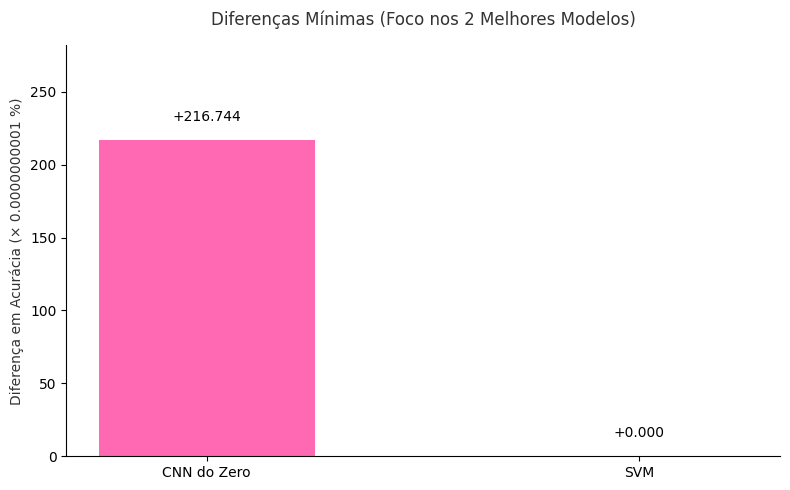

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

cor_clara = '#FFB6C1'
cor_escura = '#FF69B4'
cor_texto = '#333333'

loss, nn_accuracy = model.evaluate(validation_generator, verbose=0)
loss_cnn_zero, cnn_zero_accuracy = model_cnn_zero.evaluate(validation_generator, verbose=0)

y_pred_rf = rf.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)

y_pred_svc = svc.predict(X_val)
svc_accuracy = accuracy_score(y_val, y_pred_svc)

y_pred_knn = knn.predict(X_val)
knn_accuracy = accuracy_score(y_val, y_pred_knn)

print("\nAcurácia dos modelos:")
print("---------------------")
print(f"ResNet:                    {nn_accuracy:.10f}")
print(f"CNN do Zero:               {cnn_zero_accuracy:.10f}")
print(f"Random Forest:             {rf_accuracy:.10f}")
print(f"SVC:                       {svc_accuracy:.10f}")
print(f"KNN:                       {knn_accuracy:.10f}\n")

modelos = ['ResNet', 'CNN do Zero', 'Random Forest', 'SVM', 'KNN']
acuracia_abs = [nn_accuracy, cnn_zero_accuracy, rf_accuracy, svc_accuracy, knn_accuracy]
acuracia = [acc * 100 for acc in acuracia_abs]

plt.figure(figsize=(10, 5))
barras = plt.bar(modelos, acuracia, color=cor_clara, width=0.7)

plt.ylim(0, 100)
plt.ylabel('Acurácia (%)', color=cor_texto)
plt.title('Comparação de Desempenho (Vista Geral)', pad=15, color=cor_texto)

for barra in barras:
    altura = barra.get_height()
    plt.text(
        barra.get_x() + barra.get_width() / 2,
        altura + 2,
        f'{altura:.1f}%',
        ha='center',
        va='bottom',
        color=cor_texto
    )

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

min_acuracia = min(acuracia)
diferencas = [acc - min_acuracia for acc in acuracia]
diferencas_micro = [diff * 1e6 for diff in diferencas]

barras_diff = plt.bar(modelos, diferencas_micro, color=cor_escura, width=0.7)

plt.ylim(0, max(diferencas_micro) * 1.2)
plt.ylabel('Diferença (× 0.000001%)', color=cor_texto)
plt.title('Diferenças Ampliadas (em Micro Porcentagens)', pad=15, color=cor_texto)

for barra in barras_diff:
    altura = barra.get_height()
    if altura > 0:
        plt.text(
            barra.get_x() + barra.get_width() / 2,
            altura,
            f'+{altura:.2f}',
            ha='center',
            va='bottom',
            color='black'
        )
    else:
        plt.text(
            barra.get_x() + barra.get_width() / 2,
            0,
            f'{altura:.2f}',
            ha='center',
            va='bottom',
            color='black'
        )

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

top_indices = np.where(np.array(acuracia_abs) > rf_accuracy)[0]
modelos_top = [modelos[i] for i in top_indices]
acuracia_top_abs = [acuracia_abs[i] for i in top_indices]

plt.figure(figsize=(10, 5))

min_top_abs = min(acuracia_top_abs)
diferencas_top_abs = [a - min_top_abs for a in acuracia_top_abs]

diferencas_super_zoom = [diff * 1e6 for diff in diferencas_top_abs]

barras_super_zoom = plt.bar(modelos_top, diferencas_super_zoom, color=cor_escura, width=0.7)

plt.ylim(0, max(diferencas_super_zoom) * 1.15)
plt.ylabel('Diferença em Acurácia (× 0.000001 %)', color=cor_texto)
plt.title('Diferenças Extremas (Apenas os 4 Melhores Modelos)', pad=15, color=cor_texto)

for barra in barras_super_zoom:
    altura = barra.get_height()
    plt.text(
        barra.get_x() + barra.get_width() / 2,
        altura + (max(diferencas_super_zoom) * 0.02),
        f'+{altura:.4f}',
        ha='center',
        va='bottom',
        color='black'
    )

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

modelos_top2 = ['CNN do Zero', 'SVM']
acuracia_top2_abs = [cnn_zero_accuracy, svc_accuracy]

plt.figure(figsize=(8, 5))

min_top2_abs = min(acuracia_top2_abs)

diferencas_top2_abs = [a - min_top2_abs for a in acuracia_top2_abs]

AMPLIACAO_ESCALA = 1e10
diferencas_super_zoom2 = [diff * AMPLIACAO_ESCALA for diff in diferencas_top2_abs]

barras_super_zoom2 = plt.bar(modelos_top2, diferencas_super_zoom2, color=cor_escura, width=0.5)

max_val_zoom2 = max(diferencas_super_zoom2)
plt.ylim(0, max_val_zoom2 * 1.3)

plt.ylabel('Diferença em Acurácia (× 0.0000000001 %)', color=cor_texto)
plt.title('Diferenças Mínimas (Foco nos 2 Melhores Modelos)', pad=15, color=cor_texto)

for barra in barras_super_zoom2:
    altura = barra.get_height()
    plt.text(
        barra.get_x() + barra.get_width() / 2,
        altura + (max_val_zoom2 * 0.05),
        f'+{altura:.3f}',
        ha='center',
        va='bottom',
        color='black'
    )

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()